# 1. Import Dependencies

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.notebook import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Load the Dataset

In [5]:
# specify path to data
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

100%|██████████████████████| 2640397119/2640397119 [13:34<00:00, 3239892.05it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
5000
8000


- STL-10 dataset은 torchvision에서 기본적으로 제공
- 96x96 크기의 RGB 컬러 이미지, 5000개 train 이미지, 8,000개 test 이미지를 포함

In [6]:
# define transformation with normalization
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
]) # use mean and std for ImageNet

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

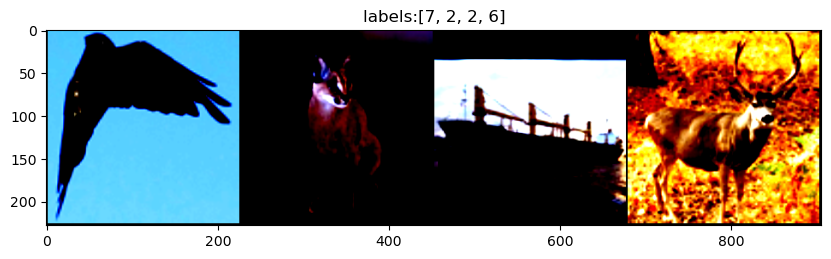

In [8]:
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    
    # clipping
    npimg_tr = np.clip(npimg_tr, 0, 1)
    
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(10)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

# 3. Construct the Model
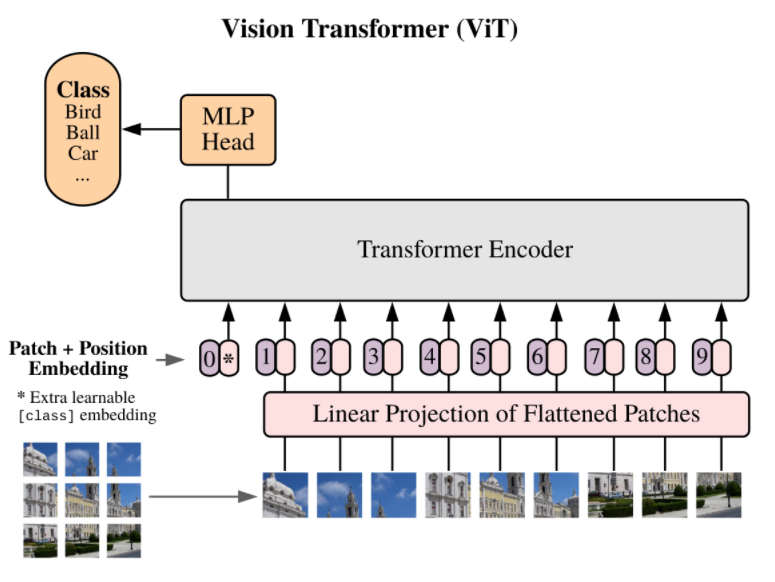

### 3.1. Patch Embedding

In [17]:
# 이미지를 input으로 받았을 때, 각각의 patch로 나누고 이를 linear projection해서 flatten하는 과정
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        # 이미지 사이즈는 224x224, 패치 사이즈는 16x16
        # 패치 개수 N = WH/P^2 = (224x224)/16^2 = 196
        # 가로 패치 14개, 세로 패치 14개
        self.patch_size = patch_size
        # Conv2d를 거쳐서 input image를 (p x p) 크기의 패치로 나누고 emb_size의 dimension으로 변환
        # e.g., Conv2d(in_channels, out_channels, kernel_size, stride)
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, patch_size, stride=patch_size),
            # The output of this convolutional layer has the shape (batch_size, output_channels, h, w)
            # (batch_size, emb_size, height, width) -> (batch_size, num_patches, emb_size)
            # e.g., (16, 3, 14, 14) -> (16, 196, 768)
            Rearrange('b e (h) (w) -> b (h w) e')  
        )

        # 클래스 토큰과 위치 임베딩 초기화
        # 평균이 0이고 표준 편차가 1인 정규 분포를 따르는 값들로 클래스 토큰 초기화
        self.class_token = nn.Parameter(torch.randn(1, 1, emb_size))
        # 위 코드에서 class_tokens는 클래스 토큰을 포함하는 tensor
        # 첫 번째 '1'은 하나의 클래스 토큰이 있음을 뜻하고 두 번째 '1'은 시퀀스 길이(클래스 토큰이 1개), 마지막은 임베딩 벡터의 크기
        
        # 패치의 위치 정보에 대한 임베딩 초기화
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        # (): 배치 차원이 아직 없음 ~ 원래는 tensor에 class_token이 존재하지 않음 
        # n: 토큰의 수 ~ 시퀀스의 길이, 클래스 토큰의 경우 1
        # e: 임베딩 크기, 768
        # 배치 크기 'b'와 일치하도록 클래스 토큰을 반복하도록 요청
        class_tokens = repeat(self.class_token, '() n e -> b n e', b=b)
        # 배치 사이즈는 32이므로, 클래스 토큰은 32번 반복되어(배치의 각 이미지에 대해) '(32, 1, 768)' 형태의 class_tokens 생성
        # 클래스 토큰을 입력에 추가
        x = torch.cat([class_tokens, x], dim=1)
        # 위치 임베딩을 투영된 패치에 추가
        x += self.positions
        return x

# 요약
# 이미지를 각 패치만큼 잘라서 각 벡터로 병합하여 flatten하고, 이를 임베딩 공간에 projection하여 패치 임베딩을 시퀀스로 병합
# 그리고 시퀀스의 가장 앞단에 class_token을 넣는 과정을 모든 배치만큼 반복
# 이미지 1: [CLS_token, Patch_1_vec, Patch_2_vec, ..., Patch_16_vec]
# 이미지 2: [CLS_token, Patch_1_vec, Patch_2_vec, ..., Patch_16_vec]
# ...
# last img: [CLS_token, Patch_1_vec, Patch_2_vec, ..., Patch_16_vec]

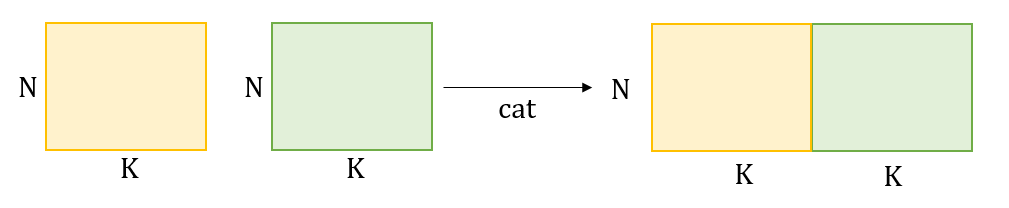

In [18]:
# Check PatchEmbedding
x = torch.randn(16, 3, 224, 224).to(device)
# general representation of image in PyTorch: (batch_size, channels, height, width)
patch_embedding = PatchEmbedding().to(device)
patch_output = patch_embedding(x)
print('[batch, 1+num of patches, emb_size] = ', patch_output.shape) # 클래스 토큰을 추가했기 때문에 patch의 수 + 1한 값이 나옴
# 패치 임베딩한 벡터의 맨 앞에 CLS(Class Token)이 추가됨
# e.g., [ [CLS], Patch_1, Patch_2, ..., Patch_N ]

[batch, 1+num of patches, emb_size] =  torch.Size([16, 197, 768])


### 3.2. Multi-Head Attention
- Q, K, V<br>
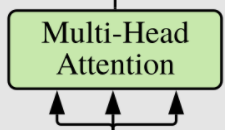

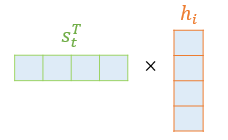

In [27]:
# MultiHeadAttention
class MultiHeadAttention(nn.Module):
    # embedding size는 768, 8개의 헤드로 병렬 처리, 드롭아웃 적용 X(probability = 0)
    def __init__(self, emb_size=768, num_heads=8, dropout=0):
        super().__init__()
        self.emb_size = emb_size # 임베딩 크기 초기화
        self.num_heads = num_heads # 헤드 수 초기화 ~ 각 헤드마다 Q, K, V가 각각 따로 있음
        # 헤드의 역할 ~ 여러 사람이 각자 다른 시각으로 하나의 그림을 보는 것과 같음
        # more detail
        # 헤드 1은 한 패치가 바로 인접한 패치와 어떻게 관련되는지에 초점을 맞출 수 있음
        # 헤드 2는 한 패치가 이미지 반대쪽에 있는 패치와 어떻게 관련되는지에 초점을 맞출 수 있음
        # 헤드 3은 한 패치와 다른 패치 간의 색상의 유사성에 중점을 둘 수 있음
        # 헤드 4는 texture 유사성에 중점을 둘 수 있음
        
        self.queries = nn.Linear(emb_size, emb_size)
        self.keys = nn.Linear(emb_size, emb_size)        
        self.values = nn.Linear(emb_size, emb_size)
        
        self.att_drop = nn.Dropout(dropout) # 드롭아웃 X
        
        self.projection = nn.Linear(emb_size, emb_size) # 각 헤드의 출력을 기존의 임베딩 공간에 projection
        # 왜 필요한가? - Multi-Head Attention의 결과를 효율적으로 결합하고, 원래의 임베딩 공간으로 다시 변환하기 위해 필요

    def forward(self, x, mask=None):
        # head의 수만큼 Q, K, V를 나눔
        # batch_size, seq_len(cls_token + flattened_patches), (head, head_dim) -> batch_size, head, seq_len, head_dim
        # == b, 197, 728 -> b, 8, 197, 91
        queries = rearrange(self.queries(x), 'b n (h d) -> b h n d', h=self.num_heads)
        keys = rearrange(self.keys(x), 'b n (h d) -> b h n d', h=self.num_heads)
        values = rearrange(self.values(x), 'b n (h d) -> b h n d', h=self.num_heads)
        
        # 마지막 축을 기준으로 dot product의 합을 각 배치에 대해서 heads만큼 병렬로 계산해서 attention scores 계산
        # 이 결과 나오는 출력은 [batch_size, num_heads, query_len, key_len]
        attention_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # Attention Score = QKᵀ
        # 아인슈타인 합 규약(Einstein summation convention): https://blog.naver.com/wndrlf2003/221552061651

        # mask 연산이 없으므로 Pass
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        # 임베딩 차원이 큰 경우, Attention Score(dot product의 결과)가 매우 커질 수 있음
        # Self-Attention을 얻기 위해서는 Attention Score가 Softmax activation function을 통과해야 하는데,
        # Attention Score가 크면, Softmax()가 Backpropagation 중 미분 값이 매우 작아져 기울기 소실 혹은 기울기 폭주 문제가 발생할 수 있기 때문에 스케일링 진행 
        scaling = self.emb_size ** (1/2)
        # softmax()를 통해 Attention Distribution을 구함
        att = F.softmax(attention_scores, dim=-1) / scaling
        att = self.att_drop(att) # 드롭아웃 X
        
        # 각 헤드의 어텐션 가중치와 Value를 Weighted Sum하여 각 헤드의 최종 Attention Value를 구함
        out = torch.einsum('bhal, bhlv -> bhav', att, values) # softmax(QKᵀ)에 대해서 Value 값 가중합하여 최종 attention Value를 구함
        out = rearrange(out, 'b h n d -> b n (h d)') # 여러 헤드에서 나온 결과를 결합하여 하나의 벡터로 변환
        out = self.projection(out) # 각 헤드의 출력을 기존의 임베딩 공간에 projection
        return out

In [28]:
# Check MultiHeadAttention
MHA = MultiHeadAttention().to(device)
MHA_output = MHA(patch_output)
print(MHA_output.shape)

torch.Size([16, 197, 768])


### 3.3. Residual Connection(Skip-Connection)
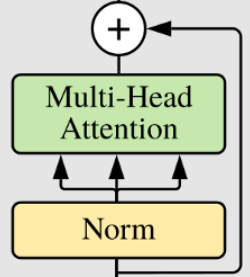

In [29]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

### 3.4. FeedForwardBlock
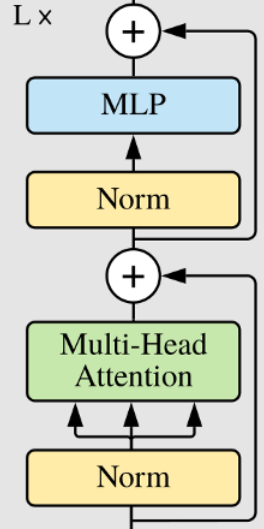

In [32]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [33]:
# check
x = torch.randn(16,1,128).to(device)
model = FeedForwardBlock(128).to(device)
output = model(x)
print(output.shape)

torch.Size([16, 1, 128])


### 3.5. TransformerEncoderBlock
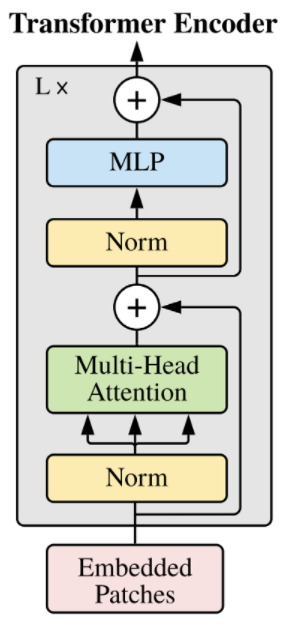

In [34]:
# Now create the Transformer Encoder Block
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

In [35]:
# Check TransformerEncoderBlock
model = TransformerEncoderBlock().to(device)
output = model(patch_output).to(device)
print(output.shape)

torch.Size([16, 197, 768])


### 3.6. TransformerEncoder

In [36]:
# TransformerEncoder consists of L blocks of TransformerBlock
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [37]:
# Check TransformerEncoder
model = TransformerEncoder().to(device)
output = model(patch_output)
print(output.shape)

torch.Size([16, 197, 768])


### 3.7. ClassificationHead
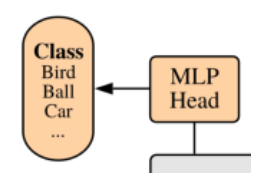

In [40]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size = 768, n_classes = 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

In [41]:
# check
x = torch.randn(16, 1, 768).to(device)
model = ClassificationHead().to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


### 3.8. ViT
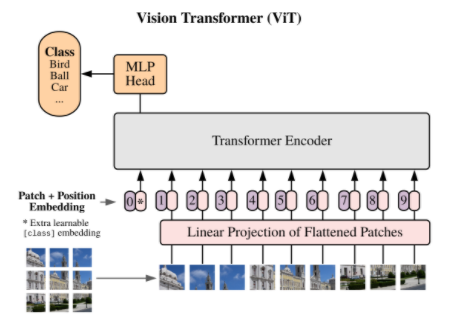

In [42]:
class ViT(nn.Sequential):
    def __init__(self, in_channels = 3, patch_size = 16, emb_size = 768, img_size = 224, depth = 12, n_classes = 10, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size = emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [43]:
# Check
x = torch.randn(16,3,224,224).to(device)
model = ViT().to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


### 3.9. Check the Model & Summary

In [44]:
model = ViT().to(device)
summary(model, (3, 224, 224), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1

# 4. Train the Model

In [45]:
# define the loss function, optimizer and lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [46]:
# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [47]:
# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric

In [48]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [49]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [50]:
# Start training
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr= 0.01
Copied best model weights!
train loss: 3.159802, val loss: 2.642753, accuracy: 15.89, time: 2.4116 min
----------
Epoch 1/99, current lr= 0.01
Copied best model weights!
train loss: 2.295884, val loss: 2.293322, accuracy: 16.62, time: 4.8361 min
----------
Epoch 2/99, current lr= 0.01
Copied best model weights!
train loss: 2.097434, val loss: 2.037901, accuracy: 20.96, time: 7.2639 min
----------
Epoch 3/99, current lr= 0.01
train loss: 2.009711, val loss: 2.086491, accuracy: 23.05, time: 9.6933 min
----------
Epoch 4/99, current lr= 0.01
Copied best model weights!
train loss: 2.002282, val loss: 1.952833, accuracy: 25.11, time: 12.1857 min
----------
Epoch 5/99, current lr= 0.01
Copied best model weights!
train loss: 1.952492, val loss: 1.908448, accuracy: 26.15, time: 14.6427 min
----------
Epoch 6/99, current lr= 0.01
train loss: 1.907737, val loss: 1.964026, accuracy: 27.27, time: 17.1196 min
----------
Epoch 7/99, current lr= 0.01
Copied best model wei

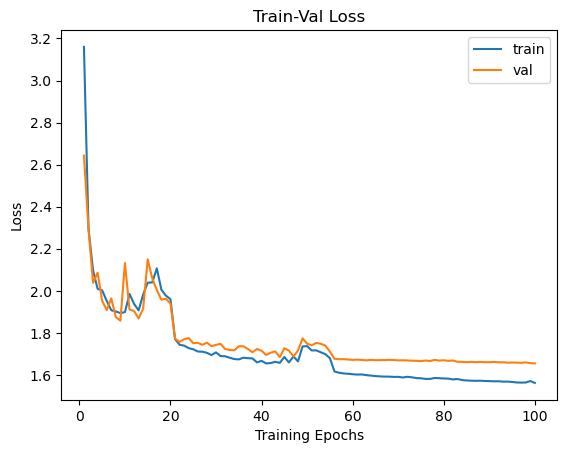

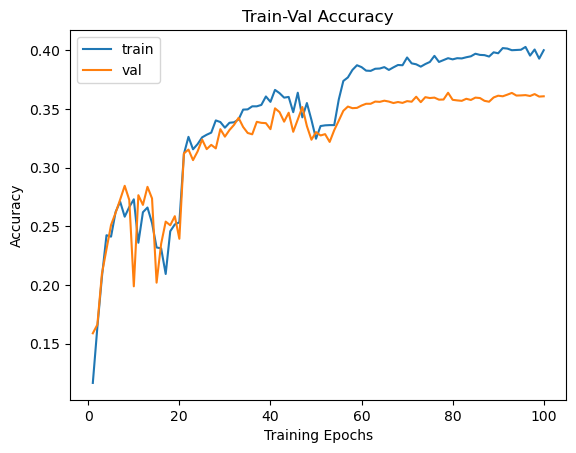

In [51]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [58]:
# Print out the model's learned parameters
for name, param in model.named_parameters():
    if param.requires_grad:  # Only include parameters that are being learned
        print(f"Parameter: {name}")
        print(param.data)
        print(f"Shape: {param.shape}\n")

Parameter: 0.class_token
tensor([[[-3.5567e+00, -5.6271e-01, -9.8508e-01,  1.2534e+00, -1.2984e+00,
          -9.6195e-01, -6.7667e-01,  9.2074e-01,  1.6676e+00,  1.0915e+00,
           2.6511e-02,  7.7821e-02,  1.5696e+00, -8.3909e-01,  1.0719e+00,
          -9.9499e-01,  1.4016e-01,  8.1332e-01, -1.2326e+00,  1.6801e+00,
          -9.4380e-01, -7.5371e-01, -7.4359e-01,  9.2859e-01,  3.3988e-01,
          -9.9002e-01,  1.8635e+00,  1.7726e+00, -9.9752e-01,  1.1748e-01,
          -9.6599e-01,  1.7979e-01,  2.2760e-01, -1.4350e+00, -2.0589e+00,
          -6.4893e-01,  2.6248e-01, -1.5298e+00, -1.2469e+00, -1.4254e+00,
          -1.1385e-01,  4.7478e-01,  3.9864e-01, -1.2623e+00,  4.4419e-01,
          -1.6369e+00, -1.5190e+00, -3.8542e+00, -4.3782e-02, -1.0756e+00,
          -6.2216e-01,  1.2683e+00, -8.5968e-01, -3.2253e-01, -1.8994e-01,
          -5.1363e-01,  2.7936e-01, -1.0057e+00, -7.9009e-02, -7.0028e-01,
           2.0070e+00,  6.6062e-01,  5.4251e-01,  4.0111e-01, -1.0468e+00,


### Reference
- https://deep-learning-study.tistory.com/807